In [104]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from dataclasses import dataclass
import dataclasses
from torchinfo import summary

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

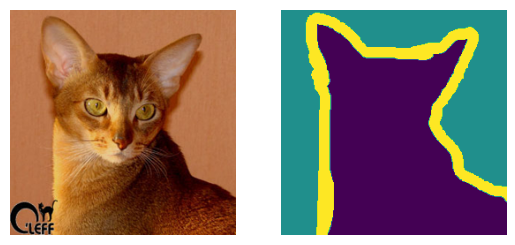

In [105]:
import requests

def get_unsplash_image():
    image_path = "stroller-unsplash.avif"

    if not os.path.exists(image_path):
        url = "https://images.unsplash.com/photo-1687017563985-a7193fcd7032"
        r = requests.get(url, allow_redirects=True)
        with open(image_path, 'wb') as fp:
            fp.write(r.content)
        # end with
    # end if

    image_256_path = "stroller-unsplash-256.png"

    if not os.path.exists(image_256_path):
        img = Image.open(image_path)
        img = img.resize((256, 256))
        img = img.convert("RGB")
        img.save(image_256_path)
    # end if

    img = Image.open(image_256_path)
    return img

def get_pet_cat_image_and_mask():
    img = Image.open(r"Torchvision/Datasets/OxfordPets/oxford-iiit-pet/images/Abyssinian_169.jpg")
    img = img.convert("RGB").resize((256, 256))
    
    mask = Image.open(r"Torchvision/Datasets/OxfordPets/oxford-iiit-pet/annotations/trimaps/Abyssinian_169.png")
    mask = mask.convert("L").resize((256, 256))
    mask = t2img((img2t(mask) * 255. - 1.) / 2.)
    return img, mask

img, mask = get_pet_cat_image_and_mask()

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis("off")

plt.show()

In [106]:
imgt = img2t(img)
print(imgt.shape)

torch.Size([3, 256, 256])


In [107]:
# ImageToPatches returns multiple flattened square patches from an
# input image tensor.
class ImageToPatches(nn.Module):
    def __init__(self, image_size, patch_size):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    # end def
    
    def forward(self, x):
        assert len(x.size()) == 4
        y = self.unfold(x)
        y = y.permute(0, 2, 1)
        return y
    # end def
# end class

In [108]:
IMG_SIZE = 256
PATCH_SIZE = 64

i2p = ImageToPatches(IMG_SIZE, PATCH_SIZE)
img_patches = i2p(imgt[None,...])
print(img_patches.shape)

mask_patches = i2p(img2t(mask)[None,...])
print(mask_patches.shape)

torch.Size([1, 16, 12288])
torch.Size([1, 16, 4096])


In [109]:
# Reshape into an image-like tensor
img_patches = img_patches.reshape(pow(IMG_SIZE // PATCH_SIZE, 2), 3, PATCH_SIZE, PATCH_SIZE)
print(img_patches.shape)

mask_patches = mask_patches.reshape(pow(IMG_SIZE // PATCH_SIZE, 2), 1, PATCH_SIZE, PATCH_SIZE)
print(mask_patches.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16, 1, 64, 64])


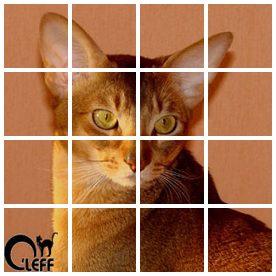

In [110]:
t2img(torchvision.utils.make_grid(img_patches, nrow=4, padding=4, pad_value=1.))

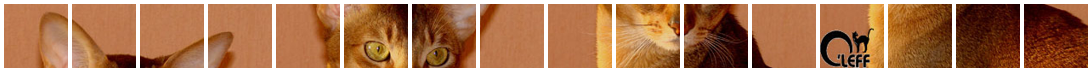

In [111]:
t2img(torchvision.utils.make_grid(img_patches, nrow=16, padding=4, pad_value=1.))

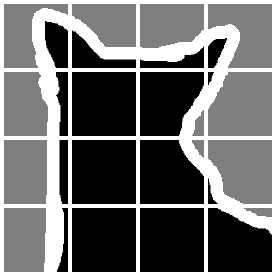

In [112]:
t2img(torchvision.utils.make_grid(mask_patches, nrow=4, padding=4, pad_value=1.))

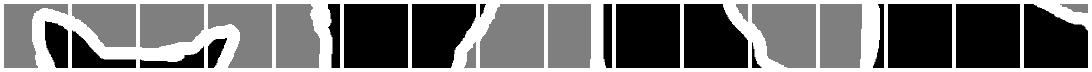

In [113]:
t2img(torchvision.utils.make_grid(mask_patches, nrow=16, padding=4, pad_value=1.))

patches.shape: torch.Size([16, 3, 64, 64])
Reshaped patches.shape: torch.Size([1, 12288, 16])
Folded patches shape: torch.Size([1, 3, 256, 256])


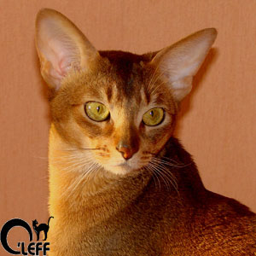

In [114]:
folder = nn.Fold(output_size=(IMG_SIZE, IMG_SIZE), kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
print(f"patches.shape: {img_patches.shape}")

# Fold expects the input to be of the form (N, C * patch_size**2, num_patches),
# so we reshape our tensor to satisfy this input constraint.
_patches = img_patches.permute(1, 2, 3, 0).reshape(1, 3 * 64 * 64, 16)
print(f"Reshaped patches.shape: {_patches.shape}")
reconstructed = folder(_patches)
print(f"Folded patches shape: {reconstructed.shape}")
t2img(reconstructed.squeeze(0))

patches.shape: torch.Size([16, 1, 64, 64])
Reshaped patches.shape: torch.Size([1, 4096, 16])
Folded patches shape: torch.Size([1, 1, 256, 256])


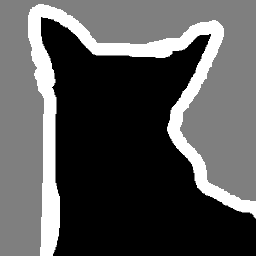

In [115]:
folder = nn.Fold(output_size=(IMG_SIZE, IMG_SIZE), kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
print(f"patches.shape: {mask_patches.shape}")

# Fold expects the input to be of the form (N, C * patch_size**2, num_patches),
# so we reshape our tensor to satisfy this input constraint.
_patches = mask_patches.permute(1, 2, 3, 0).reshape(1, 1 * 64 * 64, 16)
print(f"Reshaped patches.shape: {_patches.shape}")
reconstructed = folder(_patches)
print(f"Folded patches shape: {reconstructed.shape}")
t2img(reconstructed.squeeze(0))